# Project 1 solution: filling histograms

## Problem statement

**Goal:** Using either the `compute_mass` device function we introduced earlier or a sample of precomputed masses, fill a 120-bin histogram from 0 to 120 $\mbox{GeV}/c^2$. (Ignore overflow and underflow bins.)

In the first method, create an array with dimensions `(10000000, 120)` and have each thread fill its own row of the two-dimensional array. The columns are histogram bins. (Alternatively, you can think of it as an "array of histograms," one for each CUDA thread.)

Afterward, sum over the rows, leaving only the columns.

When your computed `bin_values` are inserted into a histogram, like this:

```python
h = Hist.new.Reg(120, 0, 120, label="mass").Double()
h.values()[:] = bin_values

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");
```

The plot should look like this:

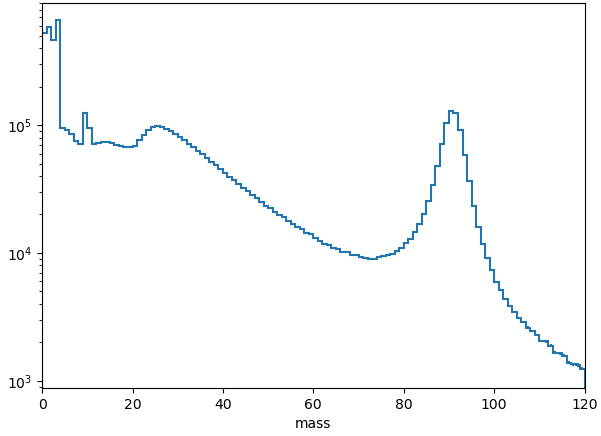

The method above uses a lot of memory; it wouldn't work if you have many histograms to fill in the same kernel.

In the second method, create a 1200-bin histogram (also from 0 to 120 $\mbox{GeV}/c^2$) as a one-dimensional array with length `1200`. All of the threads will be filling this one row of histogram bins, so they will have to be filled atomically. Declare the array dtype to be `np.uint32` and use the `nb.cuda.atomic.inc` function, or declare the array dtype to be `np.int32` and use the `nb.cuda.atomic.add` function ([documentation](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html)).

When your computed `bin_values` are inserted into a histogram, like this:

```python
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");
```

The plot should look like this:

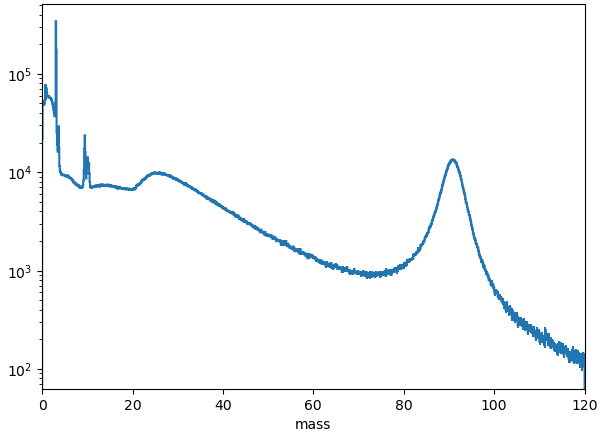

because you have 10× as many bins.

**Stretch goal:** How do the speeds of the two methods compare (using precomputed masses, not counting transfer to or from the GPU)? How does the speed scale as you reduce the number of bins?

<br><br><br><br><br>

## Loading data

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba.cuda
import numba as nb
import uproot
import awkward as ak
from hist import Hist
ak.numba.register_and_check()

To load the raw data (30‒40 seconds) and `compute_mass` so that you can fill the histogram on the fly, use this:

In [2]:
with uproot.open("root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root:Events") as tree:
    events_pt, events_eta, events_phi, events_charge = tree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], entry_stop=10000000, how=tuple)

events = ak.to_backend(ak.zip({
    "pt": events_pt,
    "eta": events_eta,
    "phi": events_phi,
    "charge": events_charge,
}), "cuda")

@nb.cuda.jit(extensions=[ak.numba.cuda], device=True)
def compute_mass(event):
    for i, mu1 in enumerate(event):
        for mu2 in event[i + 1:]:
            if mu1.charge != mu2.charge:
                return math.sqrt(2*mu1.pt*mu2.pt*(math.cosh(mu1.eta - mu2.eta) - math.cos(mu1.phi - mu2.phi)))
    return -1

To load the precomputed masses, use this:

In [3]:
with uproot.open("../data/dimuon_mass.root:tree/mass") as branch:
    mass = cp.asarray(branch.array(library="np"))

<br><br><br><br><br>

## Filling a histogram by reduction

Before starting something new, let's reestablish the workflow that would deliver mass values to our histogram-filling procedure. The function doesn't have to do anything yet, just stream over the data.

If you're computing data while you fill a histogram on the fly, the workflow is

In [4]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def on_the_fly(events):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        compute_mass(events[thread_idx])

num_threads = 1024
num_blocks = int(np.ceil(len(events) / 1024))

on_the_fly[num_blocks, num_threads](events)

If you're filling from precomputed masses, the workflow is

In [5]:
@nb.cuda.jit
def from_precomputed(mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        mass[thread_idx]

num_threads = 1024
num_blocks = int(np.ceil(len(events) / 1024))

from_precomputed[num_blocks, num_threads](mass)

In both cases, the `num_threads` and `num_blocks` is the same, so this will be the last time we redefine them.

Next, allocate the two-dimensional array (or "array of histograms"). It needs to be initially filled with zeros, and let's use `np.uint32` type because we won't be dealing with histogram weights (or negative weights).

If you do this several times, you may need to

```python
del array_of_histograms
```

before making a new one, to avoid running out of GPU memory.

In [13]:
array_of_histograms = cp.zeros((10000000, 120), dtype=np.uint32)

Regardless of our data source, we'll need to determine which bin (column index) to put each `mass` into. This can be a device function. (Don't worry if you solved it without device functions; I'm splitting everything into small functions for clarity.)

Since we'll be putting data from 0 to 120 $\mbox{GeV}/c^2$ into 120 distinct bins, we just need to truncate the floating-point mass to an integer.

In [7]:
@nb.cuda.jit(device=True)
def bin_index(x):
    return np.uint32(x)

Similarly, we can write a `fill_histogram` function as a device function. It needs to be given both a `histogram` and a value `x`.

In [8]:
@nb.cuda.jit(device=True)
def fill_histogram(histogram, x):
    if 0 <= x < 120:
        histogram[bin_index(x)] += 1

The `histogram` passed to the above function is assumed to be a thread's private histogram—one column of the `array_of_histograms`:

```python
histogram = array_of_histograms[thread_idx]
```

Therefore, we can integrate it into the filling-on-the-fly workflow like this:

In [9]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def on_the_fly_histogram(events, array_of_histograms):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        histogram = array_of_histograms[thread_idx]
        fill_histogram(histogram, compute_mass(events[thread_idx]))

on_the_fly_histogram[num_blocks, num_threads](events, array_of_histograms)

Similarly, we can integrate it into the precomputed-mass workflow like this:

In [14]:
@nb.cuda.jit
def from_precomputed_histogram(mass, array_of_histograms):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        histogram = array_of_histograms[thread_idx]
        fill_histogram(histogram, mass[thread_idx])

from_precomputed_histogram[num_blocks, num_threads](mass, array_of_histograms)

Now we have 10000000 histograms and we want 1 histogram, so we'll have to reduce it. We want a sum that coalesces the rows, so `axis=0`.

In [15]:
bin_values = array_of_histograms.sum(axis=0)

Now let's take a look at it!

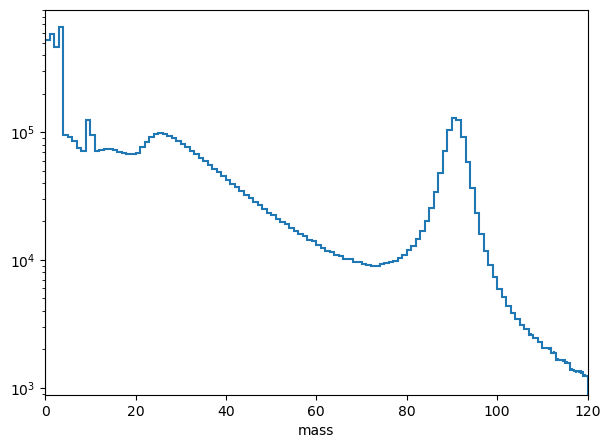

In [16]:
h = Hist.new.Reg(120, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

<br><br><br><br><br>

## Filling a histogram by atomic addition

If you had to do the above several times, you might have run out of GPU memory. The reducer method is fairly impractical.

This time, let's make a single histogram column that all threads will share, by adding atomically. Since we'll have so much memory to spare, let's give it 10× as many bins.

In [22]:
histogram = cp.zeros(1200, dtype=np.uint32)

Our previous `bin_index` device function assumed that 0 to 120 $\mbox{GeV}/c^2$ would be mapped into 120 bins. Now that we have 1200 bins, `x` needs to be scaled.

In [18]:
@nb.cuda.jit(device=True)
def bin_index_atomic(x):
    return np.uint32(10 * x)

Previously, the `fill_histogram` device function naively added `1` to the `histogram` array. Now we'll need to add `1` atomically.

According to [the documentation](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html), the `nb.cuda.atomic.inc` function is only defined for unsigned integer types and the `nb.cuda.atomic.sum` function is only defined for signed integer types. Since we chose `np.uint32`, we'll use `nb.cuda.atomic.inc`.

Incrementation takes a `val` argument, which is the maximum value each histogram bin can reach before it resets to zero. We never want that to happen, so pass `-1`. The `nb.cuda.atomic.sum` function doesn't have an argument like this.

In [19]:
@nb.cuda.jit(device=True)
def fill_histogram_atomic(histogram, x):
    if 0 <= x < 120:
        nb.cuda.atomic.inc(histogram, bin_index_atomic(x), -1)

Now when we integrate these device functions into our on-the-fly workflow or our precomputed-mass workflow, we don't need to select a histogram column by `thread_idx`.

In [20]:
@nb.cuda.jit(extensions=[ak.numba.cuda])
def on_the_fly_histogram_atomic(events, histogram):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(events):
        fill_histogram_atomic(histogram, compute_mass(events[thread_idx]))

on_the_fly_histogram_atomic[num_blocks, num_threads](events, histogram)

Similarly for the precomputed-mass workflow:

In [23]:
@nb.cuda.jit
def from_precomputed_histogram_atomic(mass, histogram):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        fill_histogram_atomic(histogram, mass[thread_idx])

from_precomputed_histogram_atomic[num_blocks, num_threads](mass, histogram)

No extra summation is needed, let's take a look at it!

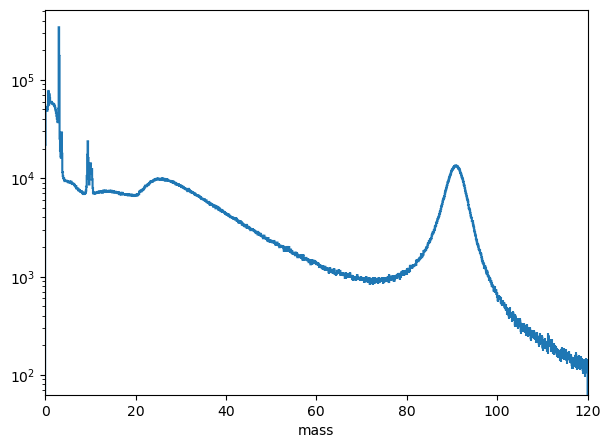

In [24]:
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = histogram.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

<br><br><br><br><br>

## Comparing computation time

These two methods have very different performance characteristics.

* The reduction method requires a lot more memory, and it gets worse with more threads.
* It also takes more time to compute a reduction, the more histograms you have to reduce.
* But the atomic method gets worse when there are fewer bins, or the distribution of data is such that more threads are trying to fill the same bin.

First, let's get a baseline measurement of the reduction method. We'll do it from precomputed masses because we're not interested in the time needed to compute masses, just the time to fill histograms.

In [25]:
%%timeit
from_precomputed_histogram[num_blocks, num_threads](mass, array_of_histograms)

9.11 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


But that's not the full cost of the reduction method; we also need to reduce.

In [26]:
%%timeit
from_precomputed_histogram[num_blocks, num_threads](mass, array_of_histograms)
bin_values = array_of_histograms.sum(axis=0)

220 ms ± 20 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In fact, most of the time is spent reducing.

Now let's get a baseline measurement of the atomic method.

In [27]:
%%timeit
from_precomputed_histogram_atomic[num_blocks, num_threads](mass, histogram)

1.61 ms ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


It's a little better than or about the same as the reduction method _without_ the reduction.

<br><br><br><br><br>

## Scaling to fewer bins to see atomic contention

To change the number of bins, we'll need to redefine the functions with `num_bins` as an argument.

(This implementation, intended only for timing studies, doesn't fill the array correctly, so I'll use an array called `scratch_space` instead of `histogram`.)

In [28]:
@nb.cuda.jit(device=True)
def bin_index_atomic_varbins(num_bins, x):
    return np.uint32(num_bins * x / 120)

@nb.cuda.jit(device=True)
def fill_histogram_atomic_varbins(histogram, num_bins, x):
    if 0 <= x < 120:
        nb.cuda.atomic.inc(histogram, bin_index_atomic_varbins(num_bins, x), -1)

@nb.cuda.jit
def from_precomputed_histogram_atomic_varbins(mass, histogram, num_bins):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        fill_histogram_atomic_varbins(histogram, num_bins, mass[thread_idx])

scratch_space = cp.empty(1200, np.uint32)

from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1200)

Now we can measure the time as we reduce the number of bins from 1200 down to 1.

In [29]:
number_of_bins = []
execution_time = []

In [30]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1200)

1.62 ms ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 1.62 ms ± 3.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [31]:
number_of_bins.append(1200)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [32]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 600)

1.83 ms ± 933 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 1.83 ms ± 933 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [33]:
number_of_bins.append(600)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [34]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 300)

2.17 ms ± 749 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.17 ms ± 749 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [35]:
number_of_bins.append(300)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [36]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 150)

2.67 ms ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.67 ms ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [37]:
number_of_bins.append(150)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [38]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 75)

3.22 ms ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.22 ms ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [39]:
number_of_bins.append(75)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [40]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 60)

3.15 ms ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.15 ms ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [41]:
number_of_bins.append(60)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [42]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 30)

2.95 ms ± 920 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.95 ms ± 920 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [43]:
number_of_bins.append(30)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [44]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 15)

3.08 ms ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.08 ms ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [45]:
number_of_bins.append(15)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [46]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 10)

3.04 ms ± 664 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.04 ms ± 664 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [47]:
number_of_bins.append(10)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [48]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 5)

3.71 ms ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.71 ms ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [49]:
number_of_bins.append(5)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [50]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 4)

3.87 ms ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.87 ms ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [51]:
number_of_bins.append(4)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [52]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 3)

4.29 ms ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.29 ms ± 2.47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [53]:
number_of_bins.append(3)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [54]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 2)

4.7 ms ± 673 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 4.7 ms ± 673 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [55]:
number_of_bins.append(2)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [56]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1)

5.63 ms ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 5.63 ms ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [57]:
number_of_bins.append(1)
execution_time.append(np.mean(_.all_runs) / _.loops)

What we find is that it generally gets worse with fewer bins—more contention—but not nearly as much as the reducer-based implementation.

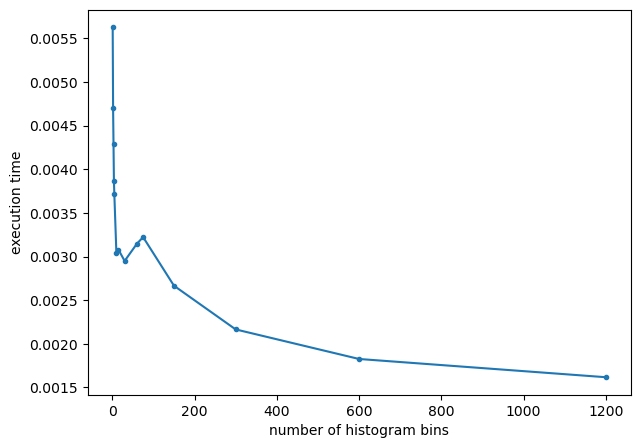

In [58]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(number_of_bins, execution_time, marker=".")
ax.set_xlabel("number of histogram bins")
ax.set_ylabel("execution time");

**Moral:** While it may be normal to duplicate histograms, fill them independently, and add them in CPU multitasking or when distributing work over a cluster, there's so much multitasking in a GPU that it no longer makes sense. Maybe some applications would want to combine the two methods, but the solution would likely involve atomics at some level.